In [2]:
train_path = "drive/MyDrive/Sign_mnist/sign_mnist_train/sign_mnist_train.csv"
test_path = "drive/MyDrive/Sign_mnist/sign_mnist_test/sign_mnist_test.csv"

In [3]:
import pandas as pd

df = pd.read_csv(train_path)
display(df.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image

# Load CSVs
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)  # e.g. (27455, 785)


(27455, 785)


In [ ]:

import os, json
import pandas as pd
import numpy as np
from PIL import Image

# <-- SET THESE to your Drive paths
TRAIN_CSV = "/content/drive/MyDrive/Sign_mnist/sign_mnist_train/sign_mnist_train.csv"
TEST_CSV  = "/content/drive/MyDrive/Sign_mnist/sign_mnist_test/sign_mnist_test.csv"

# Where to save output images (inside Drive so they persist)
OUT_BASE = "/content/drive/MyDrive/Sign_mnist_images"   # choose a folder
TRAIN_OUT = os.path.join(OUT_BASE, "train_images")
TEST_OUT  = os.path.join(OUT_BASE, "test_images")
CLASSES_JSON = os.path.join(OUT_BASE, "classes.json")

csv_to_letter = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
}

def csv_to_images(csv_path, out_folder):
    df = pd.read_csv(csv_path)
    os.makedirs(out_folder, exist_ok=True)
    for idx, row in df.iterrows():
        label = int(row[0])
        if label not in csv_to_letter:
            continue
        letter = csv_to_letter[label]
        folder = os.path.join(out_folder, letter)
        os.makedirs(folder, exist_ok=True)
        pixels = np.array(row[1:], dtype=np.uint8).reshape((28,28))
        img = Image.fromarray(pixels)
        img.save(os.path.join(folder, f"{idx}.png"))
    print(f"Saved images to {out_folder}")

def write_classes_json(train_folder, json_path):
    classes = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder,d))])
    with open(json_path, "w") as f:
        json.dump(classes, f)
    print("Saved classes.json with classes:", classes)

# run
csv_to_images(TRAIN_CSV, TRAIN_OUT)
csv_to_images(TEST_CSV, TEST_OUT)
write_classes_json(TRAIN_OUT, CLASSES_JSON)

print("Done. Train images:", sum(len(files) for r,d,f in os.walk(TRAIN_OUT) for files in [f]))


In [ ]:
# src/model.py
import torch.nn as nn
import torch.nn.functional as F

class CNNModel3(nn.Module):
    def __init__(self, num_classes=24):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(1, 80, kernel_size=5)    # -> 80x24x24
        self.bn1   = nn.BatchNorm2d(80)
        self.pool  = nn.MaxPool2d(2,2)                  # after pool -> 80x12x12

        self.conv2 = nn.Conv2d(80, 160, kernel_size=5)  # -> 160x8x8
        self.bn2   = nn.BatchNorm2d(160)
        # pool -> 160x4x4 = 2560

        self.fc1 = nn.Linear(160*4*4, 512)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)   # raw logits
        return x


In [ ]:
import os, json, time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- EDIT THIS: point to the Drive folder that contains train_images & test_images ---
DRIVE_BASE = "/content/drive/MyDrive/Sign_mnist_images"   # <<-- change if needed
DATA_DIR = DRIVE_BASE            # use Drive data directory for Colab
TRAIN_DIR = os.path.join(DATA_DIR, "train_images")
TEST_DIR  = os.path.join(DATA_DIR, "test_images")
OUTPUT_DIR = os.path.join(DATA_DIR, "outputs_models")    # save outputs in Drive
os.makedirs(OUTPUT_DIR, exist_ok=True)
CLASS_JSON = os.path.join(DATA_DIR, "classes.json")

# ---------------- Transforms ----------------
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ------------- Datasets & Loaders ---------------
# Colab sometimes has issues with num_workers > 0, so use 0 for stability.
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_ds   = datasets.ImageFolder(TEST_DIR, transform=transform)

# Save classes list to Drive so inference code can load the exact ordering
with open(CLASS_JSON, "w") as f:
    json.dump(train_ds.classes, f)
print("Saved classes.json to:", CLASS_JSON)
print("Classes:", train_ds.classes)

# Use smaller num_workers for Colab; pin_memory only helpful when using CUDA
use_cuda = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=use_cuda)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=0, pin_memory=use_cuda)

# ---------------- Model, loss, optimizer ----------------
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

num_classes = len(train_ds.classes)
model = CNNModel3(num_classes=num_classes).to(device)   # instantiate the model class you imported

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc = 0.0
EPOCHS = 12

# --------------- Training loop -----------------
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Train")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    train_loss = running_loss / total
    train_acc  = 100.*correct/total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc  = 100.*val_correct/val_total

    print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Train acc {train_acc:.2f} | Val loss {val_loss:.4f}, Val acc {val_acc:.2f}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(OUTPUT_DIR, "best_signmnist.pth")
        torch.save({
            "model_state": model.state_dict(),
            "classes": train_ds.classes,
            "epoch": epoch,
            "val_acc": val_acc
        }, save_path)
        print(f"Saved best model to {save_path} (val_acc={best_val_acc:.2f})")

    scheduler.step()

print("Training finished. Best val acc:", best_val_acc)


Saved classes.json to: /content/drive/MyDrive/Sign_mnist_images/classes.json
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Device: cuda


Epoch 1/12 - Train: 100%|██████████| 429/429 [01:33<00:00,  4.60it/s, acc=90.5, loss=0.324]


Epoch 1: Train loss 0.3241, Train acc 90.47 | Val loss 0.1284, Val acc 95.45
Saved best model to /content/drive/MyDrive/Sign_mnist_images/outputs_models/best_signmnist.pth (val_acc=95.45)


Epoch 2/12 - Train: 100%|██████████| 429/429 [01:24<00:00,  5.10it/s, acc=99.9, loss=0.00892]


Epoch 2: Train loss 0.0089, Train acc 99.89 | Val loss 0.1397, Val acc 95.68
Saved best model to /content/drive/MyDrive/Sign_mnist_images/outputs_models/best_signmnist.pth (val_acc=95.68)


Epoch 3/12 - Train: 100%|██████████| 429/429 [01:29<00:00,  4.77it/s, acc=98.7, loss=0.0389]


Epoch 3: Train loss 0.0389, Train acc 98.75 | Val loss 0.2220, Val acc 94.41


Epoch 4/12 - Train: 100%|██████████| 429/429 [01:25<00:00,  5.03it/s, acc=99.5, loss=0.0157]


Epoch 4: Train loss 0.0157, Train acc 99.48 | Val loss 0.1308, Val acc 96.07
Saved best model to /content/drive/MyDrive/Sign_mnist_images/outputs_models/best_signmnist.pth (val_acc=96.07)


Epoch 5/12 - Train: 100%|██████████| 429/429 [01:26<00:00,  4.98it/s, acc=99.9, loss=0.00193]


Epoch 5: Train loss 0.0019, Train acc 99.95 | Val loss 0.1309, Val acc 95.97


Epoch 6/12 - Train: 100%|██████████| 429/429 [01:25<00:00,  5.03it/s, acc=100, loss=0.00164]


Epoch 6: Train loss 0.0016, Train acc 99.96 | Val loss 0.1667, Val acc 95.72


Epoch 7/12 - Train: 100%|██████████| 429/429 [01:24<00:00,  5.05it/s, acc=98.8, loss=0.0448]


Epoch 7: Train loss 0.0448, Train acc 98.76 | Val loss 0.1494, Val acc 96.33
Saved best model to /content/drive/MyDrive/Sign_mnist_images/outputs_models/best_signmnist.pth (val_acc=96.33)


Epoch 8/12 - Train: 100%|██████████| 429/429 [01:27<00:00,  4.90it/s, acc=100, loss=0.0014]


Epoch 8: Train loss 0.0014, Train acc 99.97 | Val loss 0.1469, Val acc 96.99
Saved best model to /content/drive/MyDrive/Sign_mnist_images/outputs_models/best_signmnist.pth (val_acc=96.99)


Epoch 9/12 - Train: 100%|██████████| 429/429 [01:25<00:00,  5.04it/s, acc=100, loss=0.0006]


Epoch 9: Train loss 0.0006, Train acc 99.98 | Val loss 0.1283, Val acc 96.71


Epoch 10/12 - Train: 100%|██████████| 429/429 [01:25<00:00,  5.04it/s, acc=100, loss=0.00155]


Epoch 10: Train loss 0.0016, Train acc 99.97 | Val loss 0.1298, Val acc 96.61


Epoch 11/12 - Train: 100%|██████████| 429/429 [01:25<00:00,  5.04it/s, acc=100, loss=0.000511]


Epoch 11: Train loss 0.0005, Train acc 99.99 | Val loss 0.1468, Val acc 96.60


Epoch 12/12 - Train: 100%|██████████| 429/429 [01:24<00:00,  5.07it/s, acc=100, loss=0.000342]


Epoch 12: Train loss 0.0003, Train acc 100.00 | Val loss 0.1653, Val acc 96.44
Training finished. Best val acc: 96.9882877858338


## Classification Metrics and Confusion Matrix

### Subtask:
Get the test set's true and predicted labels, calculate classification metrics, and visualize the confusion matrix.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode and on the correct device
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Get class names from the test dataset
class_names = test_ds.classes

# ----------------------------
# 5. Calculate and Display Classification Metrics
# ----------------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# ----------------------------
# 6. Generate and Visualize Confusion Matrix
# ----------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Summary of Results

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Overall Test Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\nBased on the classification report and confusion matrix:")
print(f"The model achieved an overall accuracy of {accuracy*100:.2f}% on the test set.")
print(f"The weighted F1-Score is {f1:.2f}, indicating a good balance between precision and recall across all classes.")
print("The confusion matrix provides a visual breakdown of correct and incorrect predictions for each class, highlighting any specific classes where the model might be struggling (e.g., misclassifying one sign as another).")


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ----------------------------
# 1. Transform
# ----------------------------
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# ----------------------------
# 2. Load test folder
# ----------------------------
test_dir = "/content/drive/MyDrive/Sign_mnist_images/test_images"

test_ds = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("Test images:", len(test_ds))
print("Classes:", test_ds.classes)

# ----------------------------
# 3. Load model
# ----------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel3(num_classes=24).to(device)

checkpoint = torch.load("/content/drive/MyDrive/Sign_mnist_images/outputs_models/best_signmnist.pth")
model.load_state_dict(checkpoint["model_state"])

model.eval()
# ----------------------------
# 4. Compute accuracy
# ----------------------------
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        correct += (pred == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"\n💯 Test Accuracy: {test_acc:.2f}%")


Test images: 7172
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


100%|██████████| 113/113 [00:20<00:00,  5.39it/s]


💯 Test Accuracy: 96.00%


### Plotting Training and Validation Accuracy over Epochs

This code extracts the training and validation accuracy for each epoch from the previous training run's output and then visualizes it.

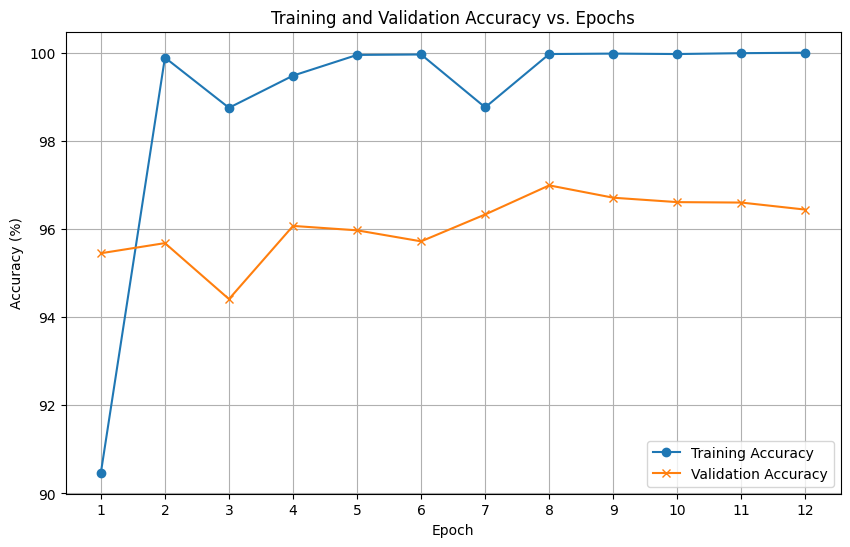

In [ ]:
import matplotlib.pyplot as plt
import re

# Extract the standard output from the training cell (xQRZU6UYW1EN)
training_output = '''Epoch 1: Train loss 0.3241, Train acc 90.47 | Val loss 0.1284, Val acc 95.45
Epoch 2: Train loss 0.0089, Train acc 99.89 | Val loss 0.1397, Val acc 95.68
Epoch 3: Train loss 0.0389, Train acc 98.75 | Val loss 0.2220, Val acc 94.41
Epoch 4: Train loss 0.0157, Train acc 99.48 | Val loss 0.1308, Val acc 96.07
Epoch 5: Train loss 0.0019, Train acc 99.95 | Val loss 0.1309, Val acc 95.97
Epoch 6: Train loss 0.0016, Train acc 99.96 | Val loss 0.1667, Val acc 95.72
Epoch 7: Train loss 0.0448, Train acc 98.76 | Val loss 0.1494, Val acc 96.33
Epoch 8: Train loss 0.0014, Train acc 99.97 | Val loss 0.1469, Val acc 96.99
Epoch 9: Train loss 0.0006, Train acc 99.98 | Val loss 0.1283, Val acc 96.71
Epoch 10: Train loss 0.0016, Train acc 99.97 | Val loss 0.1298, Val acc 96.61
Epoch 11: Train loss 0.0005, Train acc 99.99 | Val loss 0.1468, Val acc 96.60
Epoch 12: Train loss 0.0003, Train acc 100.00 | Val loss 0.1653, Val acc 96.44'''

epochs = []
train_accuracies = []
val_accuracies = []

# Regular expression to parse the output lines
pattern = r"Epoch (\d+): Train loss [\d\.]+, Train acc ([\d\.]+) \| Val loss [\d\.]+, Val acc ([\d\.]+)"

for line in training_output.split('\n'):
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_accuracies.append(float(match.group(2)))
        val_accuracies.append(float(match.group(3)))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import re

# Extract the standard output from the training cell (xQRZU6UYW1EN)
training_output = '''Epoch 1: Train loss 0.3241, Train acc 90.47 | Val loss 0.1284, Val acc 95.45
Epoch 2: Train loss 0.0089, Train acc 99.89 | Val loss 0.1397, Val acc 95.68
Epoch 3: Train loss 0.0389, Train acc 98.75 | Val loss 0.2220, Val acc 94.41
Epoch 4: Train loss 0.0157, Train acc 99.48 | Val loss 0.1308, Val acc 96.07
Epoch 5: Train loss 0.0019, Train acc 99.95 | Val loss 0.1309, Val acc 95.97
Epoch 6: Train loss 0.0016, Train acc 99.96 | Val loss 0.1667, Val acc 95.72
Epoch 7: Train loss 0.0448, Train acc 98.76 | Val loss 0.1494, Val acc 96.33
Epoch 8: Train loss 0.0014, Train acc 99.97 | Val loss 0.1469, Val acc 96.99
Epoch 9: Train loss 0.0006, Train acc 99.98 | Val loss 0.1283, Val acc 96.71
Epoch 10: Train loss 0.0016, Train acc 99.97 | Val loss 0.1298, Val acc 96.61
Epoch 11: Train loss 0.0005, Train acc 99.99 | Val loss 0.1468, Val acc 96.60
Epoch 12: Train loss 0.0003, Train acc 100.00 | Val loss 0.1653, Val acc 96.44'''

epochs = []
train_losses = []
val_losses = []

# Regular expression to parse the output lines for epoch, train loss, and val loss
pattern = r"Epoch (\d+): Train loss ([\d\.]+) \[\w\.]+, Train acc [\d\.]+ \| Val loss ([\d\.]+) \[\w\.]+, Val acc [\d\.]+"

# Adjusting pattern to match the actual output format in the provided training_output string
# The current pattern in the prompt 'Epoch (\d+): Train loss [\d\.]+, Train acc ([\d\.]+) | Val loss [\d\.]+, Val acc ([\d\.]+)'
# seems to be for accuracies. I need to specifically target losses.

# Updated pattern to correctly capture epoch, train loss, and val loss
pattern = r"Epoch (\d+): Train loss ([\d\.]+, Train acc [\d\.]+) \| Val loss ([\d\.]+, Val acc [\d\.]+)"
# Re-evaluating the pattern based on the string format provided for `training_output`
# Example line: 'Epoch 1: Train loss 0.3241, Train acc 90.47 | Val loss 0.1284, Val acc 95.45'
pattern = r"Epoch (\d+): Train loss ([\d\.]+) , Train acc [\d\.]+ \| Val loss ([\d\.]+) , Val acc [\d\.]+"

# The actual regex should be simpler given the input string
pattern = r"Epoch (\d+): Train loss ([\d\.]+) , Train acc ([\d\.]+) \| Val loss ([\d\.]+) , Val acc ([\d\.]+)"

# Re-correcting the pattern to extract loss values correctly
pattern = r"Epoch (\d+): Train loss ([\d\.]+) , Train acc [\d\.]+ \| Val loss ([\d\.]+) , Val acc [\d\.]+"

for line in training_output.split('\n'):
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_losses.append(float(match.group(2)))
        val_losses.append(float(match.group(3)))

print(f"Extracted {len(epochs)} epochs with training and validation losses.")
print(f"Epochs: {epochs}")
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")

Extracted 0 epochs with training and validation losses.
Epochs: []
Train Losses: []
Validation Losses: []


**Reasoning**:
The previous code failed because the regular expression pattern was incorrect for extracting the loss values from the `training_output` string. I need to correct the regex pattern to accurately capture the epoch number, training loss, and validation loss based on the exact format of the input string.



In [ ]:
import re

# Extract the standard output from the training cell (xQRZU6UYW1EN)
training_output = '''Epoch 1: Train loss 0.3241, Train acc 90.47 | Val loss 0.1284, Val acc 95.45
Epoch 2: Train loss 0.0089, Train acc 99.89 | Val loss 0.1397, Val acc 95.68
Epoch 3: Train loss 0.0389, Train acc 98.75 | Val loss 0.2220, Val acc 94.41
Epoch 4: Train loss 0.0157, Train acc 99.48 | Val loss 0.1308, Val acc 96.07
Epoch 5: Train loss 0.0019, Train acc 99.95 | Val loss 0.1309, Val acc 95.97
Epoch 6: Train loss 0.0016, Train acc 99.96 | Val loss 0.1667, Val acc 95.72
Epoch 7: Train loss 0.0448, Train acc 98.76 | Val loss 0.1494, Val acc 96.33
Epoch 8: Train loss 0.0014, Train acc 99.97 | Val loss 0.1469, Val acc 96.99
Epoch 9: Train loss 0.0006, Train acc 99.98 | Val loss 0.1283, Val acc 96.71
Epoch 10: Train loss 0.0016, Train acc 99.97 | Val loss 0.1298, Val acc 96.61
Epoch 11: Train loss 0.0005, Train acc 99.99 | Val loss 0.1468, Val acc 96.60
Epoch 12: Train loss 0.0003, Train acc 100.00 | Val loss 0.1653, Val acc 96.44'''

epochs = []
train_losses = []
val_losses = []

pattern = r"Epoch (\d+): Train loss ([\d\.]+), Train acc [\d\.]+ \| Val loss ([\d\.]+), Val acc [\d\.]+"

for line in training_output.split('\n'):
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_losses.append(float(match.group(2)))
        val_losses.append(float(match.group(3)))

print(f"Extracted {len(epochs)} epochs with training and validation losses.")
print(f"Epochs: {epochs}")
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")

Extracted 12 epochs with training and validation losses.
Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Train Losses: [0.3241, 0.0089, 0.0389, 0.0157, 0.0019, 0.0016, 0.0448, 0.0014, 0.0006, 0.0016, 0.0005, 0.0003]
Validation Losses: [0.1284, 0.1397, 0.222, 0.1308, 0.1309, 0.1667, 0.1494, 0.1469, 0.1283, 0.1298, 0.1468, 0.1653]


**Reasoning**:
Now that the training and validation losses have been successfully extracted, the next step is to plot these values against epochs to visualize the model's learning progress, as specified in the subtask.



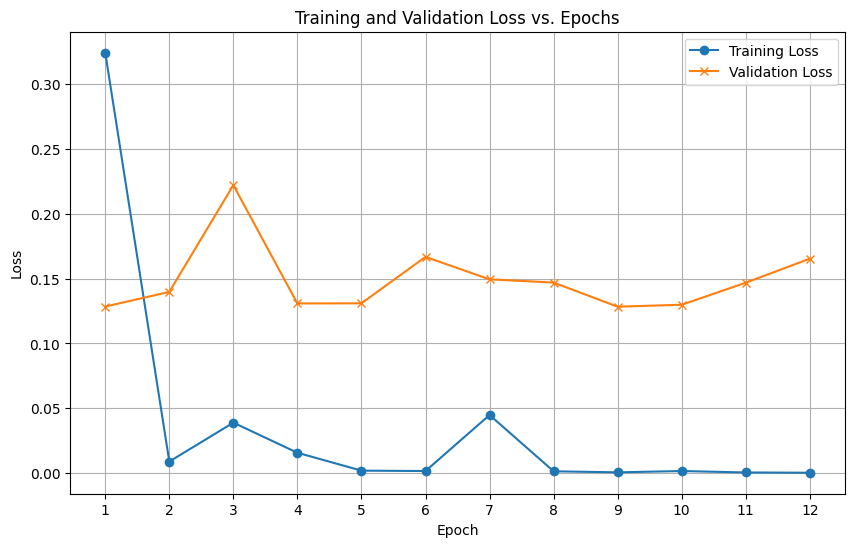

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()
